<a href="https://colab.research.google.com/github/NicholasC19/Dog-Breed-Predictor/blob/main/Copy_of_Dog_Breed_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

This cell imports the necessary Python libraries for deep learning, data handling, and visualization.

**tensorflow (TF):** An open-source platform for building and training machine learning models.

**keras:** A high-level API within TensorFlow for building neural networks easily.

**MobileNetV2:** A lightweight, efficient CNN architecture optimized for mobile and embedded vision tasks.

**matplotlib.pyplot:** A popular Python library for plotting graphs and images.

**numpy:** A library for numerical operations, especially with arrays.

**train_test_split:** A function to split data into training and test subsets.






In [ ]:
# Upload the tar file
from google.colab import files
uploaded = files.upload()  # Upload 'images.tar'

# Extract it
import tarfile

tar_file = next(iter(uploaded))  # Get uploaded filename
with tarfile.open(tar_file) as tar:
    tar.extractall()


Saving images.tar to images.tar


This uses the Colab file upload feature to let the user upload a .tar archive containing the images. This cell also extracts the contents of the uploaded.tar file.

**.tar file:** A compressed archive containing multiple files or folders.

**files.upload():** A Colab function that shows a file picker to upload from the user's computer.


**tarfile:** A Python module to work with .tar archives.

**extractall():** Unpacks all the files into the current working directory.



In [ ]:
data_dir = "/content/Images"
img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print(f"Loaded {len(class_names)} classes.")


Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.
Loaded 120 classes.


First, the parameters for loading and processing the image data are set. Then, the datasets from the folders, are split into training and validation sets.The final code block retrieves the classes (dog breed) names and enables data prefetching for performance optimization.

**data_dir:** Directory where the images are stored after extraction.

**img_size:** Images will be resized to 224x224 pixels (standard for MobileNetV2).

**batch_size:** Number of images processed in each training step.

**image_dataset_from_directory:** Reads images from subdirectories and labels them based on folder names.

**validation_split:** Fraction of data used for validation (here, 20%).

**seed:** Ensures consistent shuffling between runs.

**prefetch**: is a method used in TensorFlow's tf.data pipeline to improve the input pipeline performance by preloading data while the model is training. Without prefetch, training waits for data to be loaded from disk which is slower. With prefetching, while the model trains on the batch N, it loads batch N+1 in the background so it is ready instantly

**AUTOTUNE**: Lets TensorFlow choose the optimal buffer size automattically.

Buffer refers to the number of data batches that are prefetched in advance during training to optimize performance

buffer_size=AUTOTUNE tells TensorFlow to automatically tune how many batches it should prefetch, based on available CPU/GPU memory and system resources.

**More in depth explanations:** validation_split is a built-in argument used by Keras in certain data loading functions including image_dataset_from_directory() to automatically split to training and validation.

**validation_split=0.2:** This tells Keras to reserve 20% of the data for validation.

**subset="training"** and **subset="validation":** These tell Keras which portion to return.

***Important Notes:***

This only works when loading from directories with a valid class folder structure.

It doesn't work with general NumPy arrays or arbitrary datasets.

You must specify both validation_split and subset for the function to know how to split

In [ ]:
print("Number of classes:", len(class_names))
print(class_names[:20])  # First 20 breeds


Number of classes: 120
['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound']


Displays the total number of dog breeds and prints the first 20. (Used for assurance purposes to make sure things were correctly grabbed)

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Load pretrained MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze for initial training

# Build model
model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

First, we create a data augmentation pipeline to introduce variation in training images for better generalization purposes. Then, we load a pretrained MobileNetV2 model without its top (classification) layer and freezes it. Finally, we create the full model including preprocessing, the frozen base, and new classification layers.

**RandomFlip, RandomRotation, RandomZoom:** Techniques to create synthetic variations of images, improving generalization

**weights='imagenet':** This loads a pretrained version of MobileNetV2 that was already trained on ImageNet, a huge dataset with 1,000 classes and over a million images.

The model has already learned to extract useful features like edges, textures, shapes, patterns, etc., from images.

**include_top=False:** This removes the final classification layer (the “top” of the model), which normally outputs probabilities for the 1,000 ImageNet classes.

We remove it because we want to classify our own custom set of classes (e.g., dog breeds), not the ImageNet categories.

**base_model.trainable = False**: This freezes the weights of all the layers in base_model.

During training, the weights of this pretrained backbone will not change (frozen). We freeze it because the model already learned valuable features from large dataset (like edges, textures, shapes etc) so we don't want it to forget those by letting it be overwritten during training on our much smaller dataset. Freezing it also speedus up training and prevents overfitting on small data.

**Rescaling:** Normalizes pixel values.

**GlobalAveragePooling2D:** Reduces feature maps into a single vector.

**Dropout:** Randomly sets some neurons to 0 during training (prevents overfitting).

**Dense:** A fully connected layer, final one outputs probabilities for each class.



In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train with frozen base
initial_epochs = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=[early_stop]
)


Epoch 1/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 1070s 2s/step - accuracy: 0.3489 - loss: 2.8626 - val_accuracy: 0.7357 - val_loss: 0.8944
Epoch 2/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 1069s 2s/step - accuracy: 0.6554 - loss: 1.2024 - val_accuracy: 0.7515 - val_loss: 0.8006
Epoch 3/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 1058s 2s/step - accuracy: 0.6856 - loss: 1.0710 - val_accuracy: 0.7631 - val_loss: 0.7560
Epoch 4/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 1075s 2s/step - accuracy: 0.7063 - loss: 0.9900 - val_accuracy: 0.7590 - val_loss: 0.7674
Epoch 5/5
515/515 ━━━━━━━━━━━━━━━━━━━━ 1067s 2s/step - accuracy: 0.7126 - loss: 0.9698 - val_accuracy: 0.7629 - val_loss: 0.7558


For the first code block, it prepares the model for training. The second code block stops training early if validation loss doesn't improve for 3 consecutive epochs. The final code block trains the model for 5 epochs using frozen MobileNetV2 layers.

**Adam:** An adaptive learning rate optimizer.

**sparse_categorical_crossentropy:** is a loss function used for multi-class classification when your labels are integers (e.g., 0, 1, 2, ...), not one-hot encoded vectors. Also uses less memory.

**accuracy:** Metric to evaluate classification performance.

**EarlyStopping:** A callback that halts training when progress stalls.

**restore_best_weights:** Keeps the model at the best validation performance.

**fit():** Starts the training process.

**epochs:** Number of full passes through the training data.

In [ ]:
# Unfreeze the top layers of the base model
base_model.trainable = True

# Freeze only the first 100 layers (MobileNetV2 has ~155 layers)
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stop]
)


Epoch 5/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 1497s 3s/step - accuracy: 0.6108 - loss: 1.3949 - val_accuracy: 0.7682 - val_loss: 0.7439
Epoch 6/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 1505s 3s/step - accuracy: 0.6951 - loss: 1.0346 - val_accuracy: 0.7707 - val_loss: 0.7313
Epoch 7/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 1512s 3s/step - accuracy: 0.7077 - loss: 0.9518 - val_accuracy: 0.7699 - val_loss: 0.7342
Epoch 8/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 1461s 3s/step - accuracy: 0.7271 - loss: 0.9004 - val_accuracy: 0.7709 - val_loss: 0.7327
Epoch 9/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 1460s 3s/step - accuracy: 0.7415 - loss: 0.8445 - val_accuracy: 0.7694 - val_loss: 0.7322


1. base_model.trainable = True
Now all layers can be updated/trained, but we won't update them all

2. for layer in ... layer.trainable =False

  MobileNetV2 has ~155 layers. We keep the first 100 frozen (these learn low-level features like edges, textures), and unfreezing only the last ~55 layers, which focus more on task-specific details.

  This would:

  Keep generic visual features stable

  Allow higher-level features to adjust to new data

3. optimizer = ...(learning_rate=1e-5)

  Training a much more sensitive system.

  Higher learning rate would destroy pretrained weights

  Small learning rate ensures small careful updates

4. model.fit(
    train_ds,
    validation_data=val_ds,
    ...
)

  Now we're:

  Keeping the first 100 layers unchanged

  Slightly adjusting the last ~55 layers of MobileNetV2

  Continuing training the custom classifier added on top



In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"✅ Final Validation Accuracy: {val_acc:.2f}")


129/129 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.7612 - loss: 0.7299
✅ Final Validation Accuracy: 0.77


Evaluates the trained model on the validation set

In [ ]:
print(model.summary())


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,442,026 (24.57 MB)

 Trainable params: 2,015,160 (7.69 MB)

 Non-trainable params: 396,544 (1.51 MB)

 Optimizer params: 4,030,322 (15.37 MB)

None


Prints a detailed summary of the model architecture and parameters

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving download (1).webp to download (1) (1).webp


Uploads test images for prediction and imports preprocessing utility.

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def predict_dog_breed(img_path, model, class_names):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)[0]
    top_indices = predictions.argsort()[-3:][::-1]
    top_classes = [class_names[i] for i in top_indices]
    top_confidences = [100 * predictions[i] for i in top_indices]

    plt.imshow(img)
    plt.axis('off')
    title = "\n".join([f"{cls}: {conf:.2f}%" for cls, conf in zip(top_classes, top_confidences)])
    plt.title(title)
    plt.show()

    return list(zip(top_classes, top_confidences))


Defines a function to predict the top 3 most likely breeds for a given image and plot the result.

📷 Predicting download (1) (1).webp...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Exception ignored in: <function _xla_gc_callback at 0x7e6bafe9c2c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


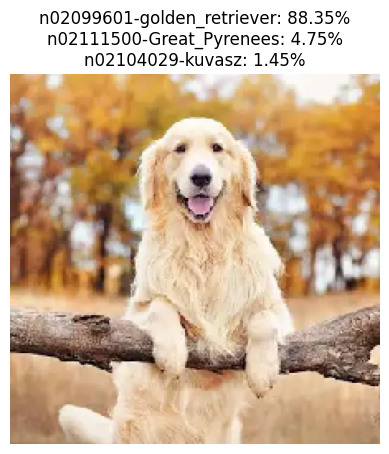

[('n02099601-golden_retriever', np.float32(88.348305)), ('n02111500-Great_Pyrenees', np.float32(4.7504177)), ('n02104029-kuvasz', np.float32(1.4487524))]


In [ ]:
for filename in uploaded.keys():
   print(f"📷 Predicting {filename}...")
   results = predict_dog_breed(filename, model, class_names)
   print(results)




Uses the prediction function on all uploaded images and prints the top breed predictions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
# Get true labels and images
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

Collects all predictions and true labels from the validation set for the confusion matrix.

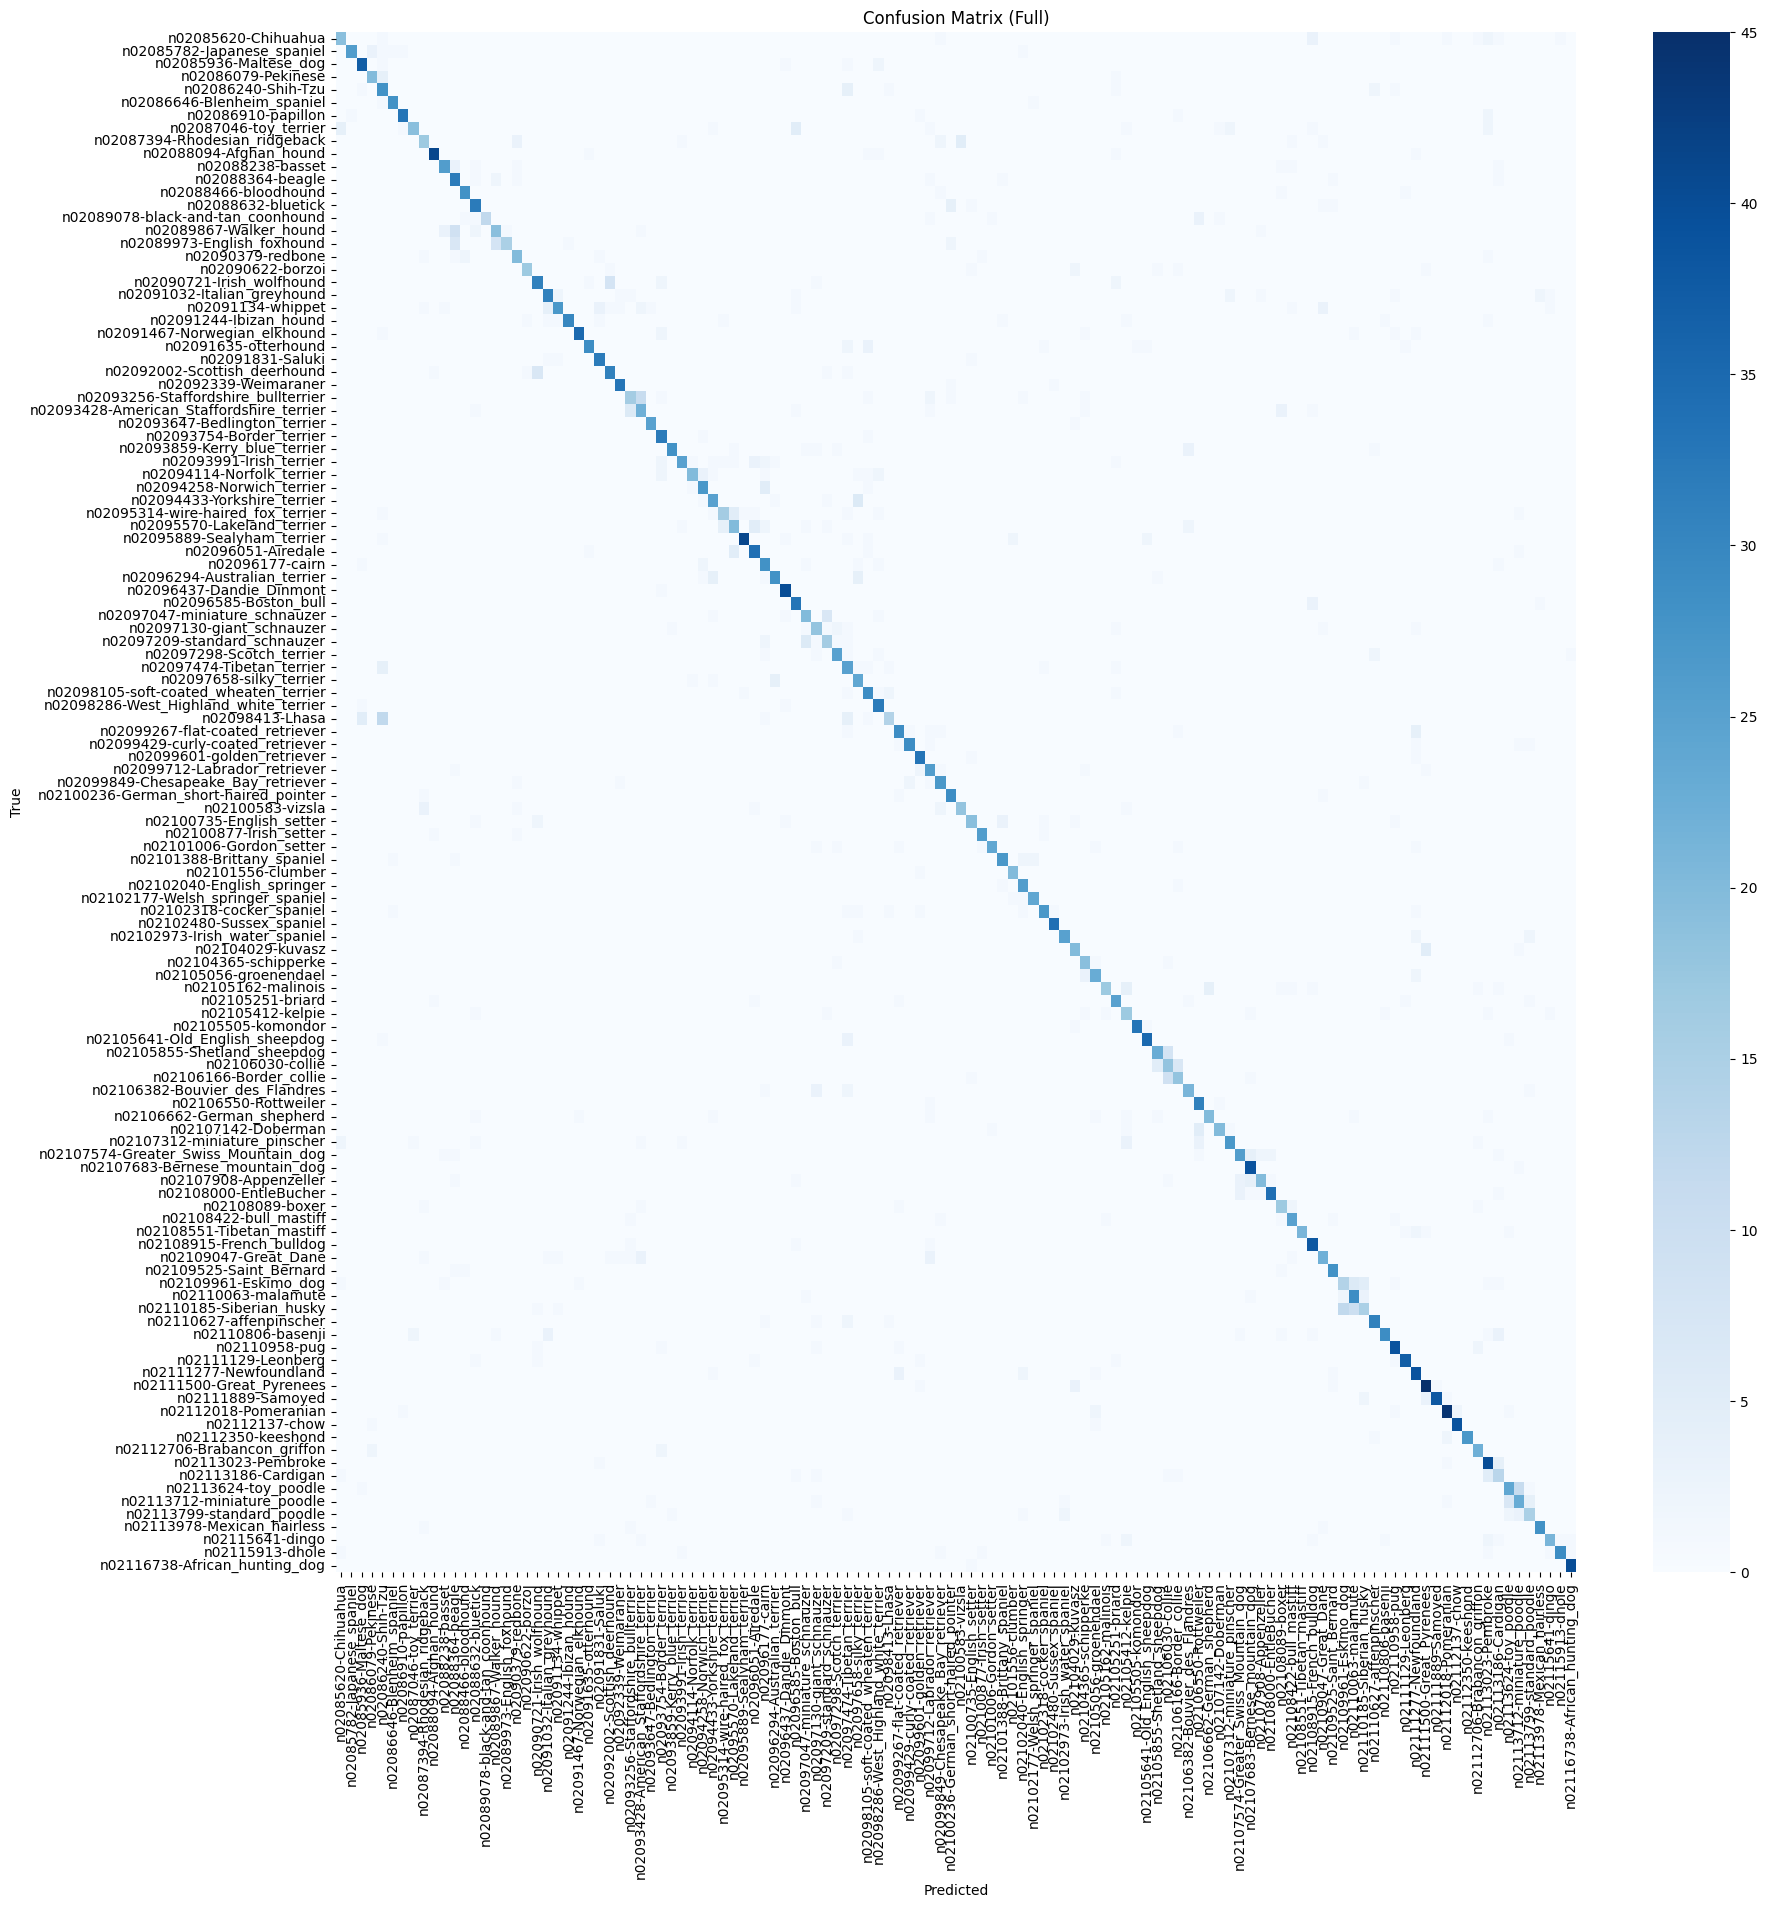

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(20, 20))  # Bigger figure for 120 classes
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Full)')
plt.show()


Displays a large confusion matrix comparing true and predicted labels across all classes.

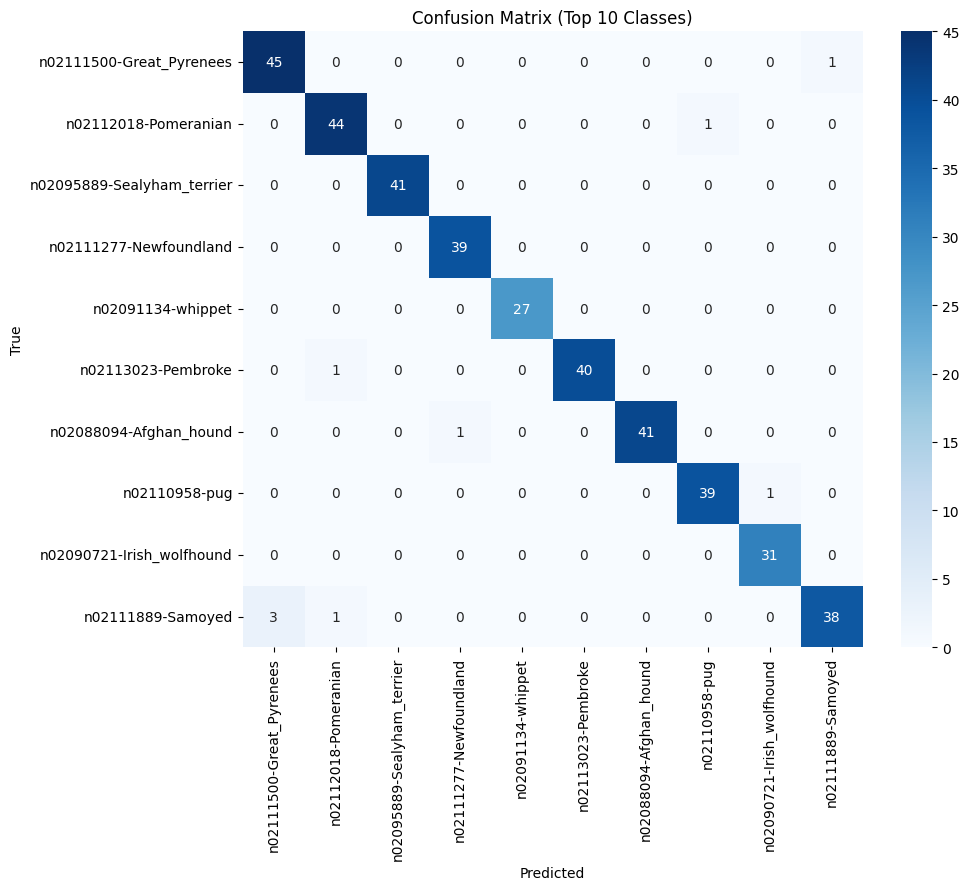

In [ ]:
import pandas as pd
from collections import Counter

# Count true label frequencies
true_counts = Counter(y_true)
top_indices = [i for i, _ in true_counts.most_common(10)]

# Filter confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=top_indices)
class_subset = [class_names[i] for i in top_indices]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_subset, yticklabels=class_subset, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Top 10 Classes)')
plt.show()


Displays a smaller confusion matrix for the 10 most common classes (Possible limitation)

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))


                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.68      0.61      0.64        31
              n02085782-Japanese_spaniel       0.96      0.79      0.87        33
                   n02085936-Maltese_dog       0.80      0.88      0.84        42
                      n02086079-Pekinese       0.77      0.80      0.78        25
                      n02086240-Shih-Tzu       0.50      0.74      0.60        38
              n02086646-Blenheim_spaniel       0.90      0.93      0.92        30
                      n02086910-papillon       0.92      0.87      0.89        38
                   n02087046-toy_terrier       0.86      0.50      0.63        38
           n02087394-Rhodesian_ridgeback       0.65      0.57      0.61        30
                  n02088094-Afghan_hound       0.93      0.89      0.91        46
                        n02088238-basset       0.81      0.76      0.79        34
               

Prints precision, recall, f1-score for each class.


**classification_report:** Gives detailed performance metrics.

**precision, recall, f1-score:** Key classification evaluation metrics.



In [ ]:
print("First 10 class names:", class_names[:10])


First 10 class names: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound']
